In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pygmt
from scipy.interpolate import griddata

# Define the regions
region1s = [-71.65, -71.52, -33.05, -32.94]
region03s = [-71.644, -71.595, -33.0495, -33.010]
spacing=(2/3)/3600
# Function to make the region a square
def make_square_region(region):
    # Calculate the width and height of the region
    width = region[1] - region[0]
    height = region[3] - region[2]
    
    # Find the maximum dimension (width or height)
    max_dimension = max(width, height)
    
    # Calculate the center of the region
    center_x = (region[0] + region[1]) / 2
    center_y = (region[2] + region[3]) / 2
    
    # Calculate the new coordinates for the square region
    new_region = [
        center_x - max_dimension / 2,
        center_x + max_dimension / 2,
        center_y - max_dimension / 2,
        center_y + max_dimension / 2
    ]
    
    return new_region

# Make regions square
region1s = make_square_region(region1s)
region03s = make_square_region(region03s)
print(region1s,region03s)
print((region1s[1]-region1s[0])/((2/3)/3600))
print(region1s[3]-region1s[2]/((2/3)/3600))

[-71.65, -71.52000000000001, -33.06, -32.92999999999999] [-71.644, -71.595, -33.05425, -33.00525]
701.9999999999754
178491.07000000004


In [2]:
grid1s_topo=pygmt.grdsample(grid='/home/alex/Downloads/rasters_COP30/output_COP30.tif',spacing=f'{2/3}s',region=region1s,outgrid='grid1s_topo.grd')
grid1s_topo=pygmt.grd2xyz(grid='grid1s_topo.grd',region=region1s)
grid1s_topo.loc[grid1s_topo['z']==0,'z']=np.nan
bath=pd.read_excel('/home/alex/StochasticSlipGenerator/jagurs_folder/grids/BahiaValparaiso.xlsx',skiprows=8,header=None)
bath.columns=['y','x','z']
bath=pygmt.blockmean(x=bath['x'],y=bath['y'],z=bath['z'],region=region1s,spacing=f'{2/3}s')
bath=pygmt.surface(data=bath,region=region1s,spacing=f'{2/3}s',outgrid='bath.grd')
bath=pygmt.grd2xyz(grid='bath.grd',region=region1s)

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values


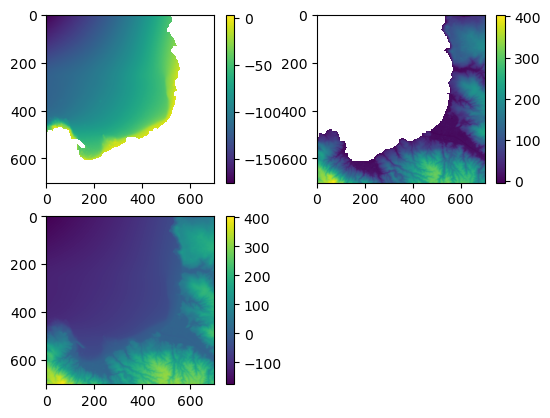

In [3]:


x,y=np.meshgrid(np.linspace(region1s[0],region1s[1],num=grid1s_topo['x'].nunique()),np.linspace(region1s[2],region1s[3],num=grid1s_topo['y'].nunique()))

topo_mask=np.isnan(grid1s_topo['z'].values.reshape(grid1s_topo['y'].nunique(),grid1s_topo['x'].nunique()))
interpolated_bathy=np.flip(griddata((bath['x'],bath['y']),bath['z'],(x,y),method='linear'),axis=0)
topobathymetry=interpolated_bathy*topo_mask
topobathymetry[topobathymetry==0]=np.nan
plt.subplot(2,2,1)
plt.imshow(topobathymetry)
plt.colorbar()
plt.subplot(2,2,2)
grid1s_topo.loc[grid1s_topo['z']==np.nan,'z']=0
topo=grid1s_topo['z'].values.reshape(grid1s_topo['y'].nunique(),grid1s_topo['x'].nunique())
plt.imshow(grid1s_topo['z'].values.reshape(grid1s_topo['y'].nunique(),grid1s_topo['x'].nunique()))
plt.colorbar()
final = np.where(np.isnan(topobathymetry),topo ,topobathymetry)
plt.subplot(2,2,3)
plt.imshow(final)
plt.colorbar()
final2=np.flip(final,axis=0)
# hacer la grilla
df = pd.DataFrame({
    'x': x.flatten(),
    'y': y.flatten(),
    'z': -final2.flatten()
})
pygmt.xyz2grd(data=df,region=region1s,spacing=f'{2/3}s',outgrid='bathy.SD04.grd',duplicate='f')
pygmt.grdsample(region=region03s,spacing=f'{2/9}s',grid='bathy.SD04.grd',outgrid='bathy.SD05.grd')
# topo
df = pd.DataFrame({
    'x': x.flatten(),
    'y': y.flatten(),
    'z': final2.flatten()
})
pygmt.xyz2grd(data=df,region=region1s,spacing=f'{2/3}s',outgrid='topo.SD04.grd',duplicate='f')
pygmt.grdsample(region=region03s,spacing=f'{2/9}s',grid='topo.SD04.grd',outgrid='topo.SD05.grd')



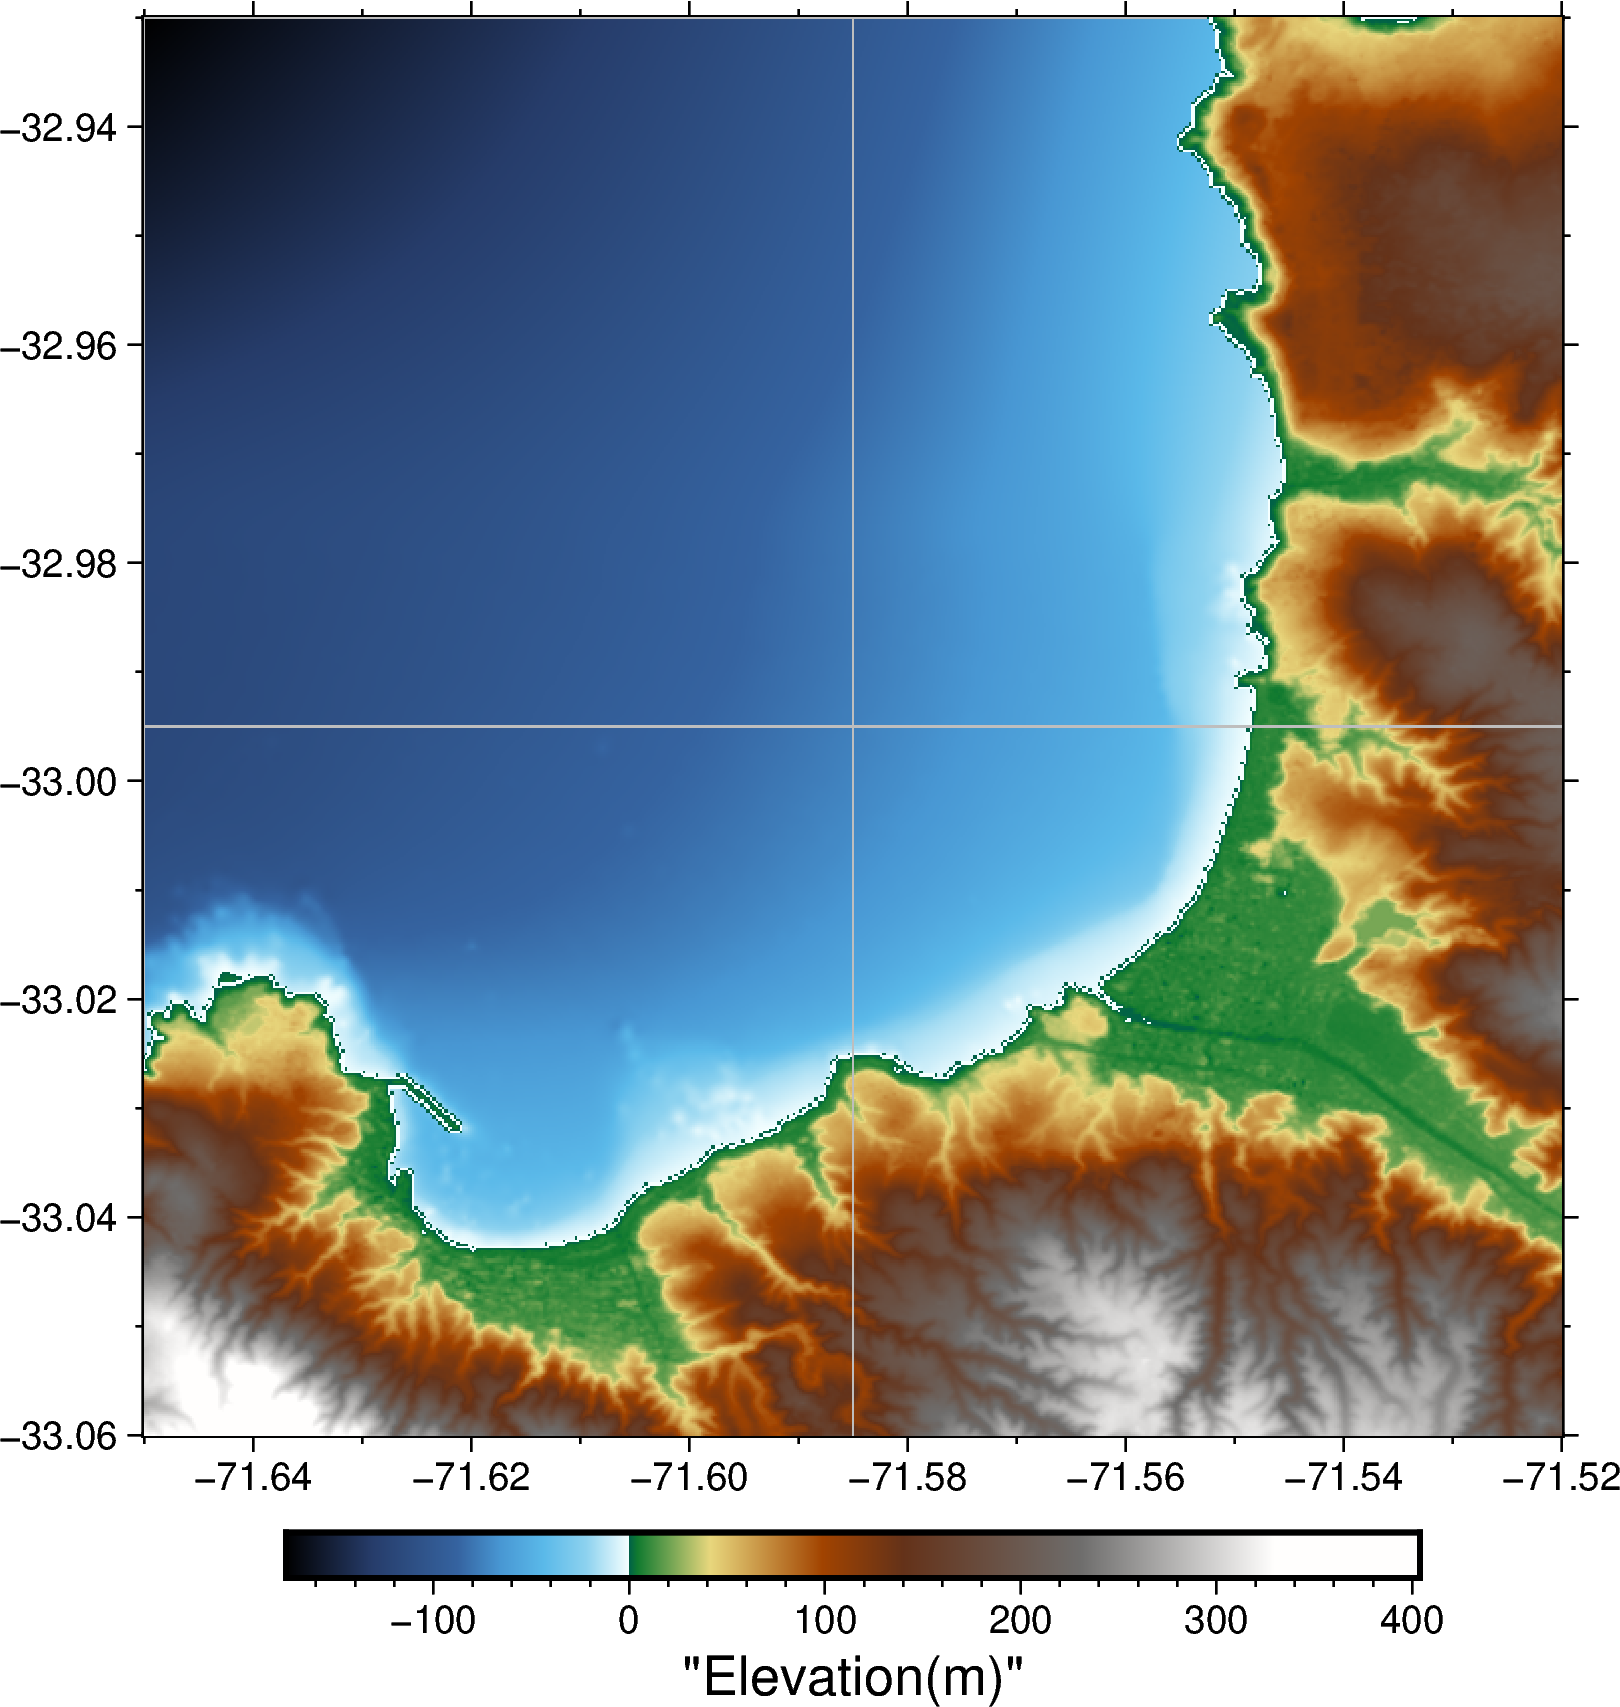

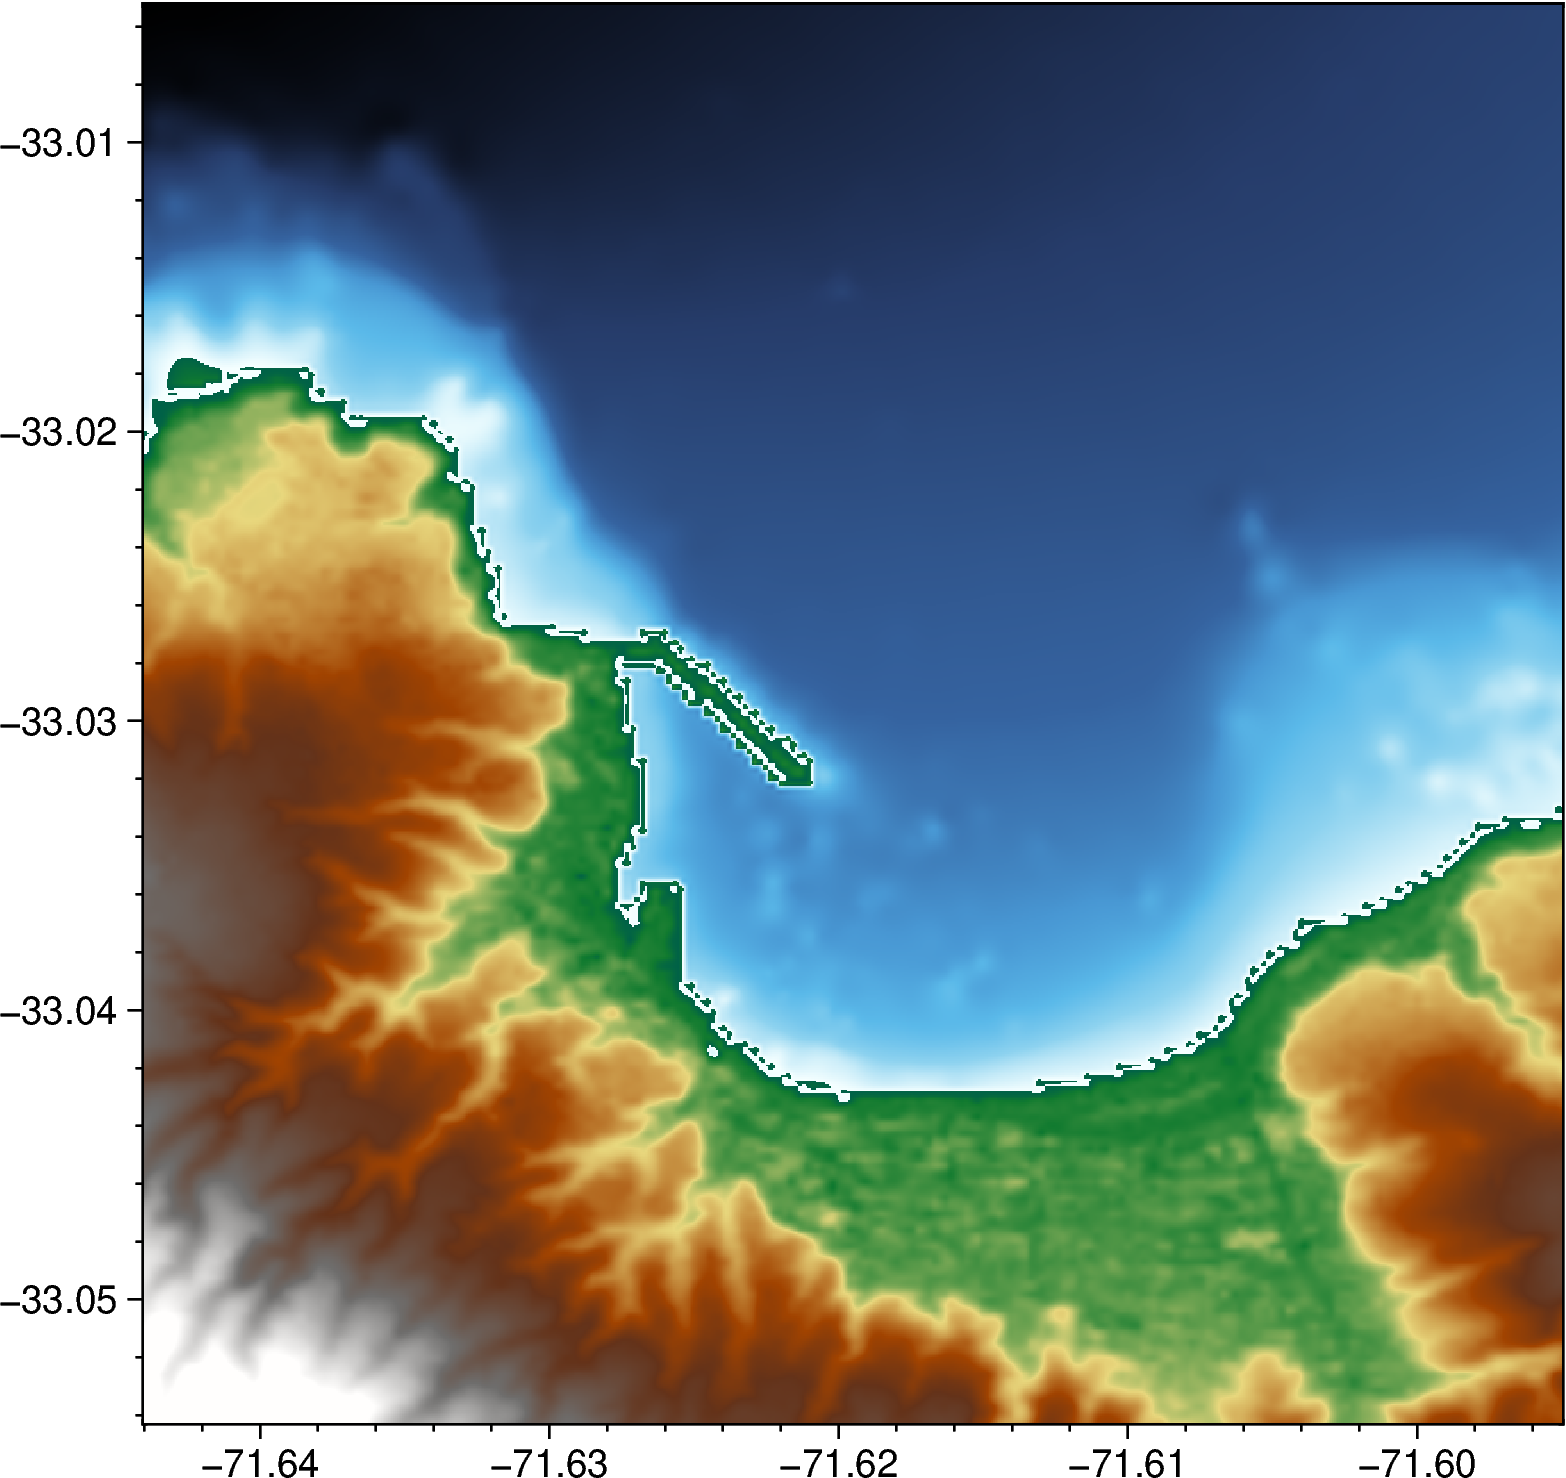

In [4]:

fig=pygmt.Figure()
fig.basemap(region=region1s,projection='X12c',frame=["afg", "WSne"])
fig.grdimage(grid='topo.SD04.grd', cmap='geo')
fig.colorbar(frame='af+l"Elevation(m)"')
fig.show()
fig2=pygmt.Figure()
fig2.basemap(region=region03s,projection='X12c',frame=True)
fig2.grdimage(grid='topo.SD05.grd', cmap='geo')
fig.colorbar(frame='af+l"Elevation(m)"')

fig2.show()

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values


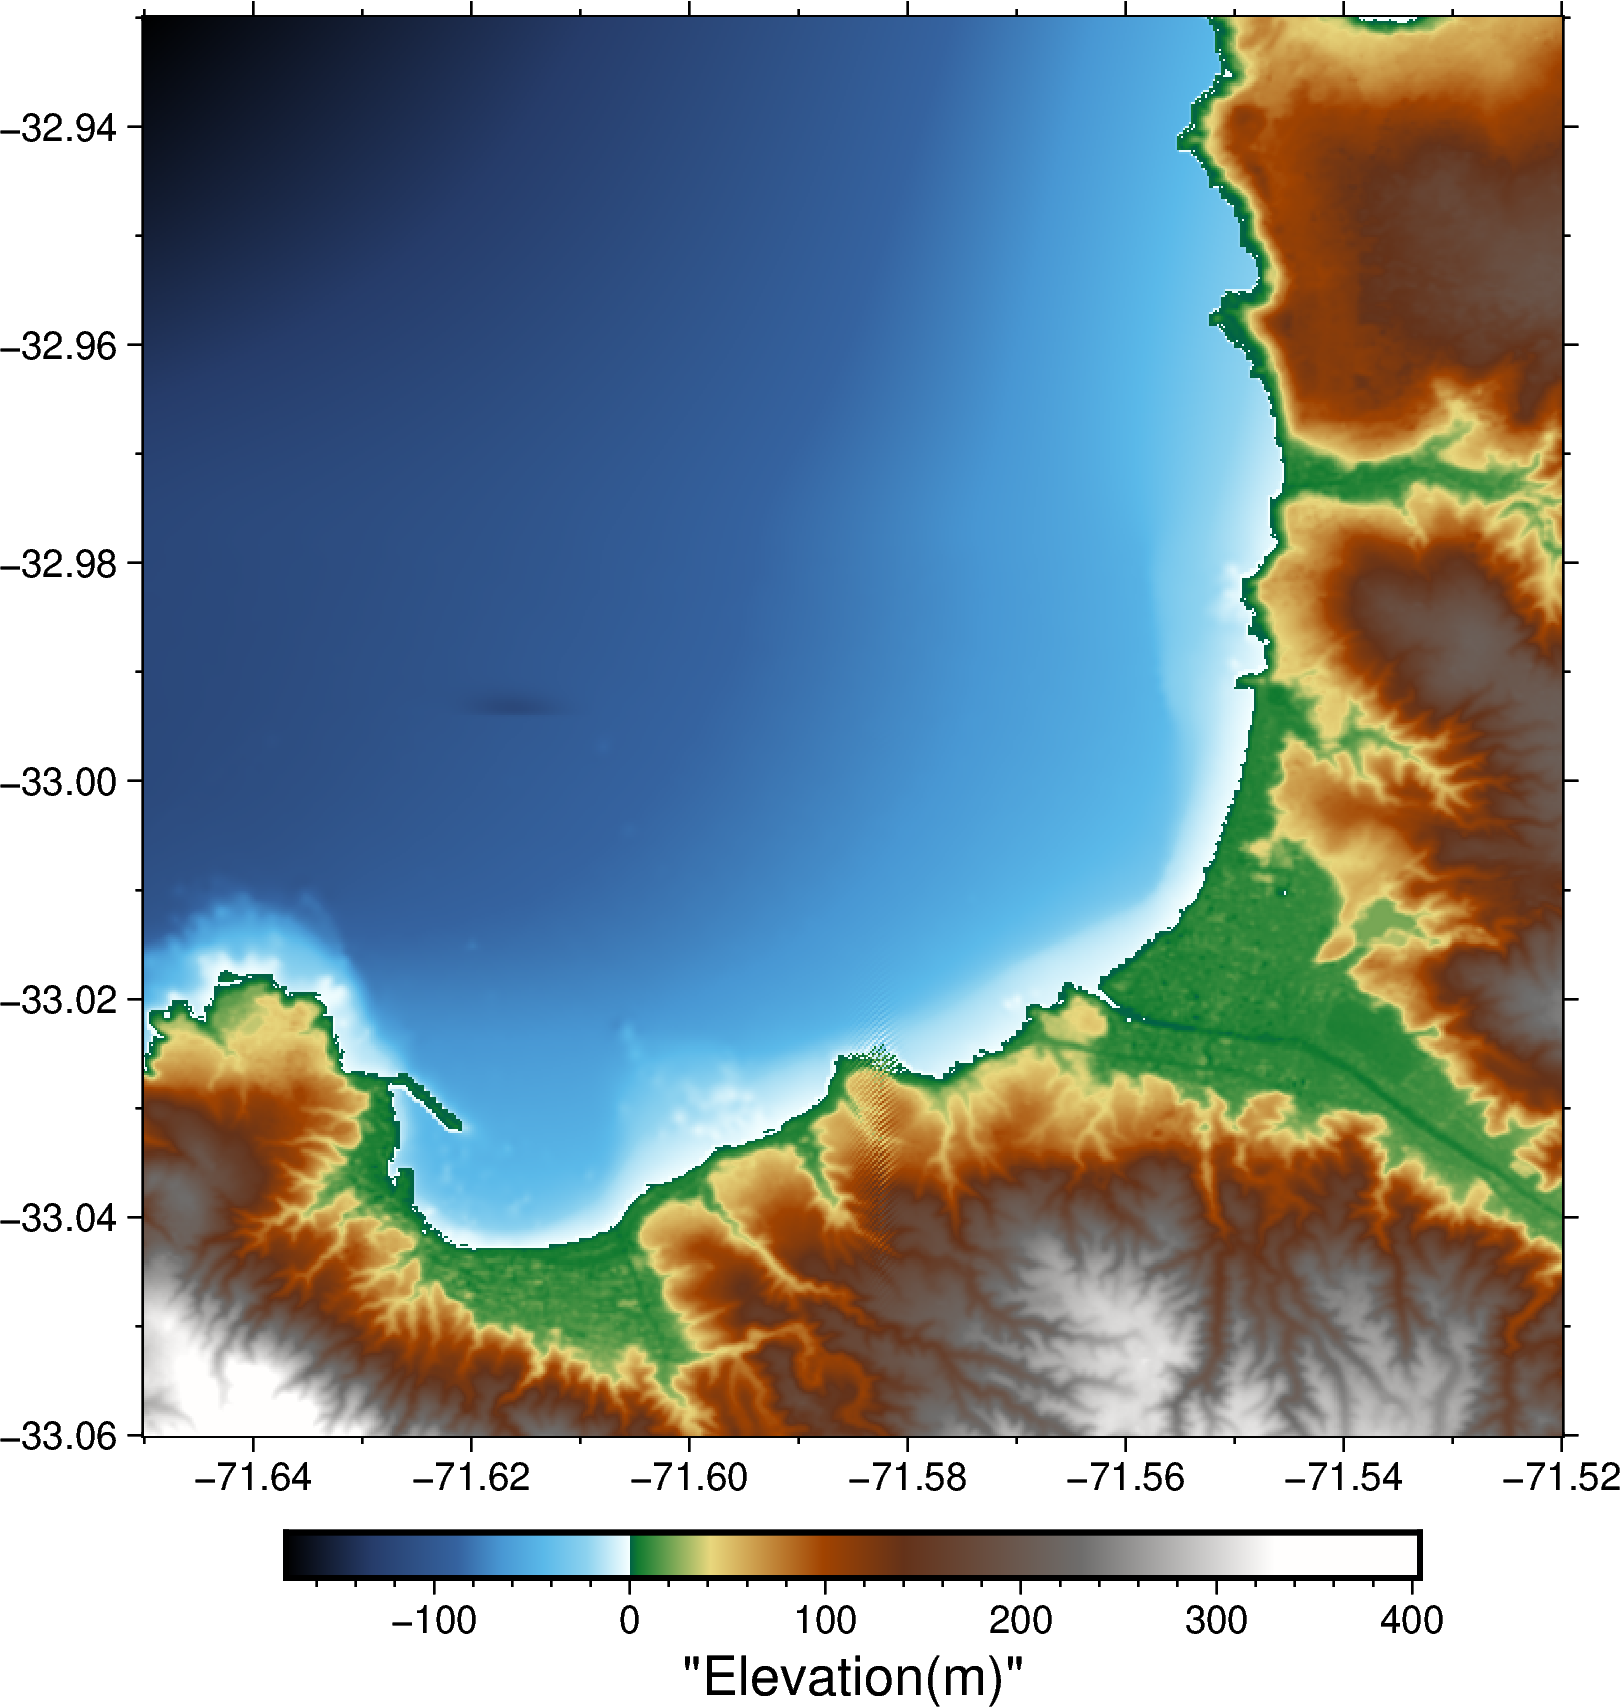

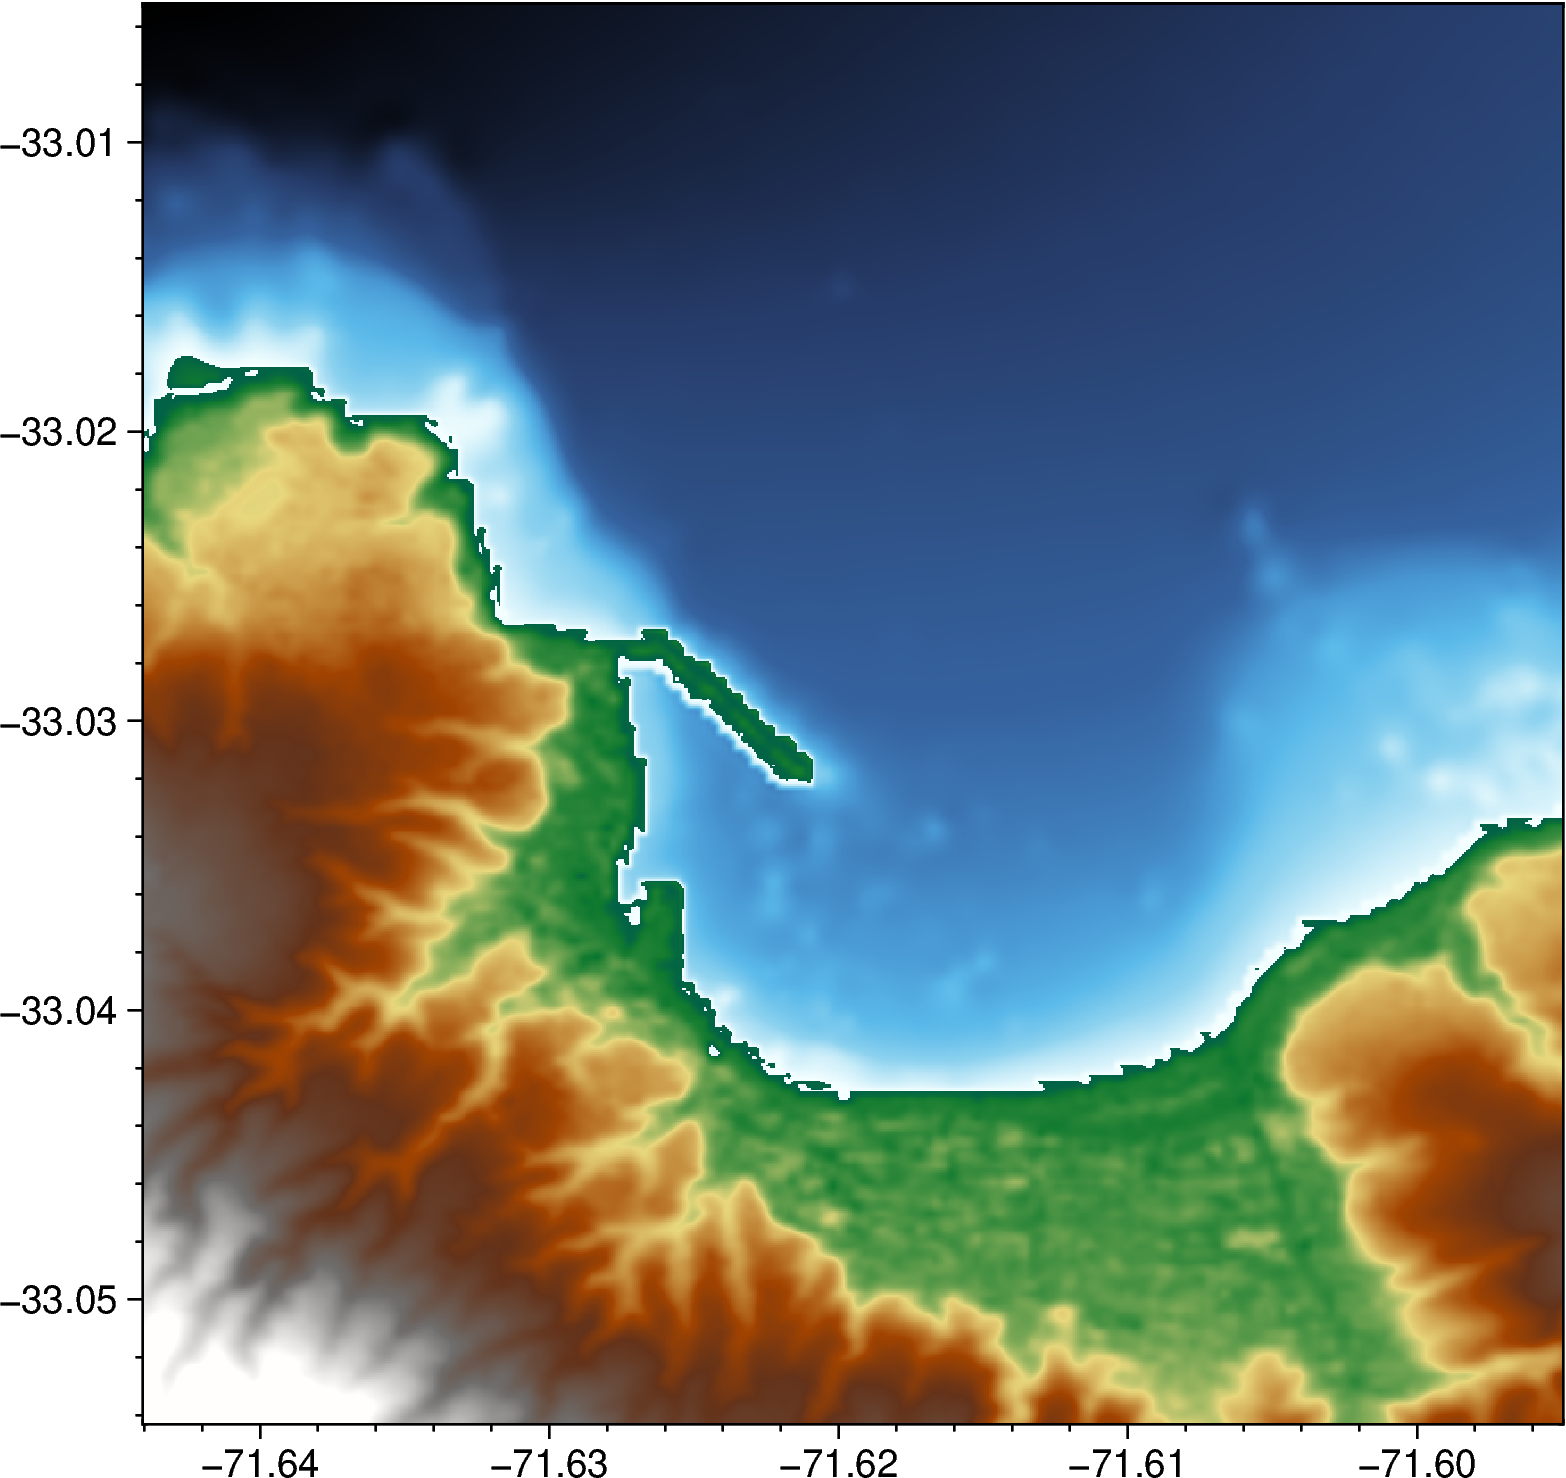

In [6]:
df = pd.DataFrame({
    'x': x.flatten(),
    'y': y.flatten(),
    'z': -final2.flatten()
})
#
blockmean=pygmt.blockmean(data=df,region=region1s,spacing=f'{2/3}s')
pygmt.surface(data=blockmean,region=region1s,spacing=f'{2/3}s',outgrid='bathy.SD04.grd')
pygmt.grdsample(region=region03s,spacing=f'{2/9}s',grid='bathy.SD04.grd',outgrid='bathy.SD05.grd')
# topo
df = pd.DataFrame({
    'x': x.flatten(),
    'y': y.flatten(),
    'z': final2.flatten()
})
blockmean2=pygmt.blockmean(data=df,region=region1s,spacing=f'{2/3}s')
pygmt.surface(data=blockmean2,region=region1s,spacing=f'{2/3}s',outgrid='topo.SD04.grd')
pygmt.grdsample(region=region03s,spacing=f'{2/9}s',grid='topo.SD04.grd',outgrid='topo.SD05.grd')


fig=pygmt.Figure()
fig.basemap(region=region1s,projection='X12c',frame=["afg", "WSne"])
fig.grdimage(grid='topo.SD04.grd', cmap='geo')
fig.colorbar(frame='af+l"Elevation(m)"')
fig.show()
fig2=pygmt.Figure()
fig2.basemap(region=region03s,projection='X12c',frame=True)
fig2.grdimage(grid='topo.SD05.grd', cmap='geo')
fig.colorbar(frame='af+l"Elevation(m)"')

fig2.show()

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
